In [1]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from dataset import GallBladderDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import torchvision.models as models
import torchsummary as summary
from model import UNET
from utils import (
    save_checkpoint,
    load_checkpoint,
    get_mean_std,
    get_transforms_value,
    get_test_loader,
    get_loaders,
    check_accuracy,
)
import torchvision.transforms as transforms

# hyperparameters etc.

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 1
NUM_WORKERS = 12
PIN_MEMORY = True

TEST_IMG_DIR = "./brain/test/images/"
TEST_MASK_DIR = "./brain/test/masks/"


model = UNET(in_channels=1, out_channels=1).to(DEVICE)
load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

test_ds = GallBladderDataset(
    image_dir=TEST_IMG_DIR,
    mask_dir=TEST_MASK_DIR,
    transform=transforms.Compose([transforms.ToTensor()]),
)
test_mean, test_std = get_mean_std(test_ds)
test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(test_mean), torch.Tensor(test_std)),
    ]
)
test_loader = get_test_loader(TEST_IMG_DIR, TEST_MASK_DIR, BATCH_SIZE, test_transforms)

check_accuracy(test_loader, model, DEVICE)


C:\Users\ytche\AppData\Local\Temp\ipykernel_23008\3376775296.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

=> Loading checkpoint
=> Loaded checkpoint successfully
3605


100%|██████████| 3605/3605 [01:13<00:00, 49.27it/s]

Got 368286988/369152000 with Pixel Accuracy 0.9976567625999451
Dice Coefficient:0.922918438911438


(tensor(0.9977, device='cuda:0'), tensor(0.9229, device='cuda:0'))

Running for n_bits=2


100%|██████████| 3605/3605 [01:20<00:00, 44.88it/s]


Got 332747794/369152000 with Pixel Accuracy 0.9013842940330505
Dice Coefficient:0.20214277505874634
n_bits=2, PC=0.9013842940330505, Dice=0.20214277505874634
Running for n_bits=4


100%|██████████| 3605/3605 [01:13<00:00, 49.27it/s]


Got 330666237/369152000 with Pixel Accuracy 0.8957455158233643
Dice Coefficient:0.5995507836341858
n_bits=4, PC=0.8957455158233643, Dice=0.5995507836341858
Running for n_bits=6


100%|██████████| 3605/3605 [01:07<00:00, 53.12it/s]


Got 356315559/369152000 with Pixel Accuracy 0.9652272462844849
Dice Coefficient:0.8131253719329834
n_bits=6, PC=0.9652272462844849, Dice=0.8131253719329834
Running for n_bits=8


100%|██████████| 3605/3605 [01:44<00:00, 34.38it/s]


Got 368215960/369152000 with Pixel Accuracy 0.9974644184112549
Dice Coefficient:0.9220286011695862
n_bits=8, PC=0.9974644184112549, Dice=0.9220286011695862
Running for n_bits=10


100%|██████████| 3605/3605 [02:07<00:00, 28.26it/s]


Got 368270485/369152000 with Pixel Accuracy 0.9976121187210083
Dice Coefficient:0.9228744506835938
n_bits=10, PC=0.9976121187210083, Dice=0.9228744506835938
Running for n_bits=12


100%|██████████| 3605/3605 [01:57<00:00, 30.56it/s]


Got 368283340/369152000 with Pixel Accuracy 0.9976468682289124
Dice Coefficient:0.9228531122207642
n_bits=12, PC=0.9976468682289124, Dice=0.9228531122207642
Running for n_bits=14


100%|██████████| 3605/3605 [01:59<00:00, 30.14it/s]


Got 368286192/369152000 with Pixel Accuracy 0.9976546764373779
Dice Coefficient:0.9229004979133606
n_bits=14, PC=0.9976546764373779, Dice=0.9229004979133606
Running for n_bits=16


100%|██████████| 3605/3605 [01:55<00:00, 31.32it/s]


Got 368287021/369152000 with Pixel Accuracy 0.9976568222045898
Dice Coefficient:0.9229176640510559
n_bits=16, PC=0.9976568222045898, Dice=0.9229176640510559


100%|██████████| 3605/3605 [01:51<00:00, 32.32it/s]


Got 368286988/369152000 with Pixel Accuracy 0.9976567625999451
Dice Coefficient:0.922918438911438


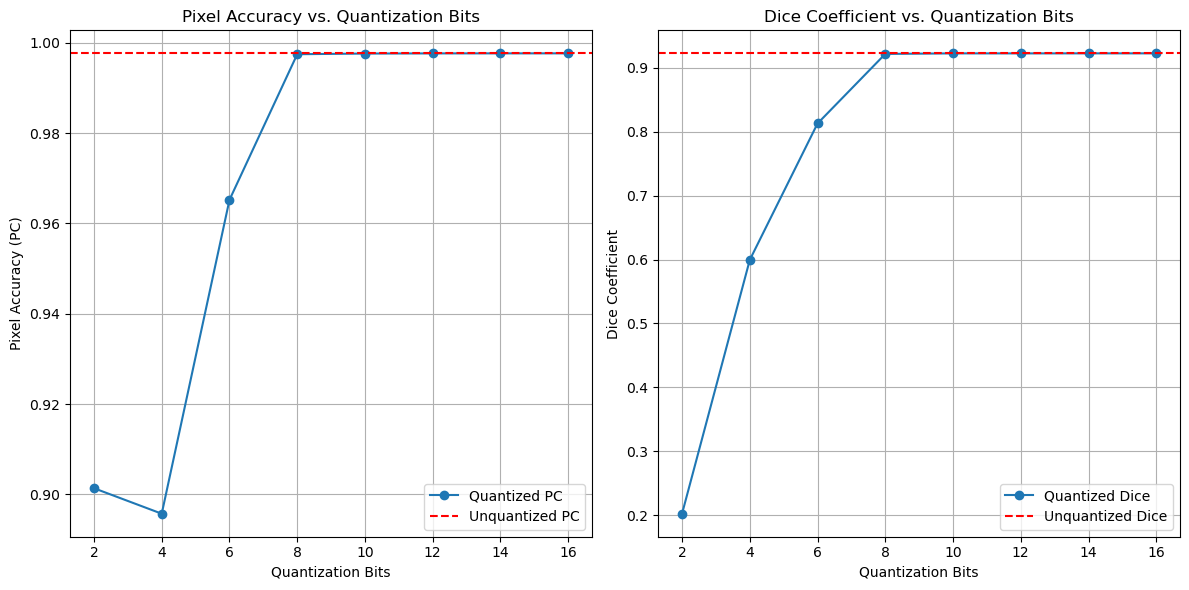

In [2]:
# print(model)

# # 钩子函数定义
# def hook_fn(module, input, output):
#     global original_output
#     original_output = output.clone().detach()  
#     # tmp=output
#     tensor_min, tensor_max = output.min(), output.max()
#     normalized_tensor = (output - tensor_min) / (tensor_max - tensor_min)
#     scaled_tensor = normalized_tensor * (2**4 - 1)
#     quantized_tensor = torch.round(scaled_tensor).int()  # 转为整数
#     tmp = quantized_tensor.float() / (2**4 - 1) * (tensor_max - tensor_min) + tensor_min
#     return tmp

# # 注册钩子函数
# model.conv1.register_forward_hook(hook_fn)

# PC,Dice=check_accuracy(test_loader, model, DEVICE)

def hook_fn(module, input, output, n_bits):
    global original_output
    original_output = output.clone().detach() 

    tensor_min, tensor_max = output.min(), output.max()
    normalized_tensor = (output - tensor_min) / (tensor_max - tensor_min)
    scaled_tensor = normalized_tensor * (2**n_bits - 1)
    quantized_tensor = torch.round(scaled_tensor).int()  # 转为整数
    tmp = quantized_tensor.float() / (2**n_bits - 1) * (tensor_max - tensor_min) + tensor_min
    return tmp

class QuantizeHook:
    def __init__(self, n_bits):
        self.n_bits = n_bits

    def __call__(self, module, input, output):
        return hook_fn(module, input, output, self.n_bits)

results = {}
n_bits_list = [2, 4, 6, 8, 10, 12, 14, 16]  # 不同量化阶数

for n_bits in n_bits_list:
    print(f"Running for n_bits={n_bits}")
    
    # 移除之前的钩子（如果有）
    if hasattr(model.conv1, '_forward_hooks'):
        model.conv1._forward_hooks.clear()

    # 注册新的钩子
    quantize_hook = QuantizeHook(n_bits)
    model.conv1.register_forward_hook(quantize_hook)

    # 评估模型
    PC, Dice = check_accuracy(test_loader, model, DEVICE)
    results[n_bits] = (PC, Dice)

    print(f"n_bits={n_bits}, PC={PC}, Dice={Dice}")
    
if hasattr(model.conv1, '_forward_hooks'):
    model.conv1._forward_hooks.clear()
unquantized_PC,unquantized_Dice=check_accuracy(test_loader, model, DEVICE)

unquantized_PC=unquantized_PC.cpu().numpy()
unquantized_Dice=unquantized_Dice.cpu().numpy()

n_bits = list(results.keys())
quantized_PC = [result[0].cpu().numpy() for result in results.values()]
quantized_Dice = [result[1].cpu().numpy() for result in results.values()]

plt.figure(figsize=(12, 6))

# Pixel Accuracy (PC) 图
plt.subplot(1, 2, 1)
plt.plot(n_bits, quantized_PC, marker='o', label='Quantized PC')
plt.axhline(y=unquantized_PC, color='r', linestyle='--', label='Unquantized PC')
plt.title('Pixel Accuracy vs. Quantization Bits')
plt.xlabel('Quantization Bits')
plt.ylabel('Pixel Accuracy (PC)')
plt.legend()
plt.grid()

# Dice Coefficient 图
plt.subplot(1, 2, 2)
plt.plot(n_bits, quantized_Dice, marker='o', label='Quantized Dice')
plt.axhline(y=unquantized_Dice, color='r', linestyle='--', label='Unquantized Dice')
plt.title('Dice Coefficient vs. Quantization Bits')
plt.xlabel('Quantization Bits')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig("bit_to_dice_on_test_dataset.png", dpi=1024, bbox_inches='tight', pad_inches=0)
plt.show()

In [3]:
import numpy as np
weight = model.conv1.weight
weight = weight.detach().cpu().numpy().squeeze()

print(weight)

closest_diff_indices = [1480]

for batch_idx, (x, y) in enumerate(test_loader):
    if batch_idx == closest_diff_indices[0]:
        x = x.to(DEVICE)
        y = y.to(DEVICE).unsqueeze(1)
        tmp = x.cpu().numpy().squeeze()
        # output_conv_1= np.convolve(x, weight, 'valid')
        
        

[[-0.3693022  -0.01066846 -0.1258502 ]
 [-0.3631103   0.06318058  0.12932211]
 [-0.07583695 -0.01936208  0.23523524]]


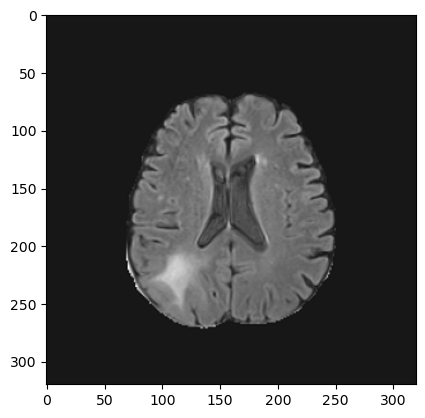

In [4]:
for idx in closest_diff_indices:
    image, target = test_loader.dataset[idx]
    
    # 可视化该图片
    plt.imshow(image.cpu().numpy()[0], cmap='gray')  # 转换为可显示格式
    plt.show()
    tmp=image.cpu().numpy()[0]
    # np.savetxt(f"output_{idx}.csv", tmp, delimiter=",", fmt="%.2f", comments="")


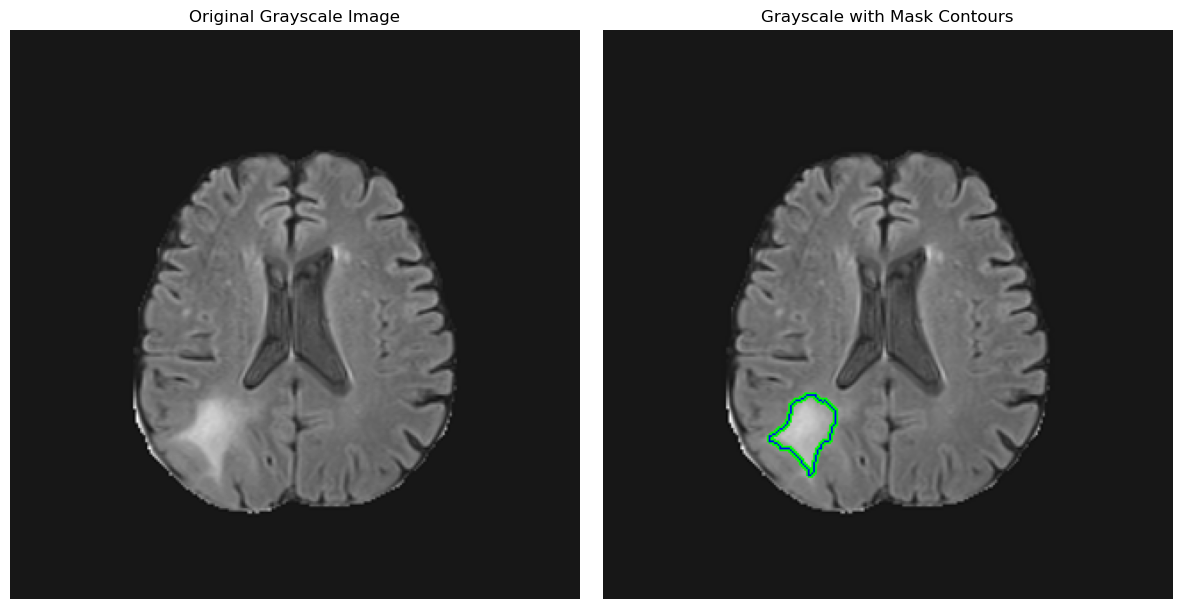

In [5]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import os

 
def draw_mask_contours_on_grayscale(image, mask, color=(255, 0, 0), thickness=2): 
    """ 
    在灰度图上绘制分割掩膜的轮廓 
 
    Args: 
        image (numpy.ndarray): 输入的灰度图像。 
        mask (numpy.ndarray): 分割掩膜（灰度图，非二值也可）。 
        color (tuple): 轮廓颜色，默认为红色 (255, 0, 0)。 
        thickness (int): 轮廓线的粗细，默认为2。 
 
    Returns: 
        numpy.ndarray: 带有轮廓的灰度图（伪彩色）。 
    """ 
    # 确保图像是 uint8 类型
    if image.dtype != np.uint8:
        image_min = image.min() 
        image_max = image.max() 
        normalized_image = (image - image_min) / (image_max - image_min)  # 归一化到0到1 
        image = np.clip(normalized_image * 255, 0, 255).astype(np.uint8)  # 将图像范围调整到0到255并转换为np.uint8类型
    
    # 如果是灰度图，将其转换为彩色图像
    if len(image.shape) == 2:  
        image_colored = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  
    else:
        image_colored = image  # 如果已经是彩色图
    
    # 将掩膜转为二值图
    binary_mask = (mask > 0).astype(np.uint8) * 255  # 转换为0和255  
    
    # 找到轮廓  
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  
    
    # 绘制轮廓到图像上  
    image_with_contours = cv2.drawContours(image_colored, contours, -1, color, thickness)  
    
    return image_with_contours  

def get_nth_file(path,n):
    # 获取当前目录下的所有文件和文件夹
    all_items = os.listdir(path)
    # 过滤出文件
    files = [f for f in all_items if os.path.isfile(f)]
    # 按文件名排序
    files.sort()
    
    # 检查n是否超出范围
    if n <= 0 or n > len(files):
        return None
    
    # 返回第n个文件
    return files[n - 1]


# 加载npy文件 
# gray_image = np.load("brain/test/images/100035.npy")  # 灰度图像 
# mask = np.load("brain/test/masks/100035.npy")  # 掩膜 
for idx in closest_diff_indices:
    max_diff_image, max_diff_target = test_loader.dataset[idx]
    gray_image=max_diff_image.cpu().numpy()[0]
    mask=max_diff_target
    # gray_image=get_nth_file(TEST_IMG_DIR,idx)
    # mask=get_nth_file(TEST_MASK_DIR,idx)
    
    
    # 在灰度图像上绘制掩膜轮廓 
    result_image = draw_mask_contours_on_grayscale(gray_image, mask, color=(0, 255, 0), thickness=2) 
    result_image = draw_mask_contours_on_grayscale(result_image, mask, color=(255, 0, 0), thickness=1) 
    
    # 可视化灰度图像和结果 
    plt.figure(figsize=(12, 6)) 
    
    # 显示原始灰度图像 
    plt.subplot(1, 2, 1) 
    plt.imshow(gray_image, cmap="gray") 
    plt.title("Original Grayscale Image") 
    plt.axis("off") 
    
    # 显示带轮廓的图像 
    plt.subplot(1, 2, 2) 
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))  # OpenCV的BGR格式转换为RGB 
    plt.title("Grayscale with Mask Contours") 
    plt.axis("off") 
    
    # 显示图像 
    plt.tight_layout() 
    plt.show()


In [6]:
import pandas as pd
import torch

csv_file_path = "o_quant.csv"  # 替换为你的 CSV 文件路径
df = pd.read_csv(csv_file_path, header=None)

tensor = torch.tensor(df.values, dtype=torch.float32)
cuda_tensor = tensor.cuda()

# 打印结果
print("Original Tensor (CPU):", tensor)
print("CUDA Tensor (GPU):", cuda_tensor)

output_o_1480 = cuda_tensor+model.conv1.bias

Original Tensor (CPU): tensor([[0.2989, 0.2989, 0.2989,  ..., 0.2989, 0.2989, 0.2989],
        [0.2989, 0.2989, 0.2989,  ..., 0.2989, 0.2989, 0.2989],
        [0.2989, 0.2989, 0.2989,  ..., 0.2989, 0.2989, 0.2989],
        ...,
        [0.2989, 0.2989, 0.2989,  ..., 0.2989, 0.2989, 0.2989],
        [0.2989, 0.2989, 0.2989,  ..., 0.2989, 0.2989, 0.2989],
        [0.2989, 0.2989, 0.2989,  ..., 0.2989, 0.2989, 0.2989]])
CUDA Tensor (GPU): tensor([[0.2989, 0.2989, 0.2989,  ..., 0.2989, 0.2989, 0.2989],
        [0.2989, 0.2989, 0.2989,  ..., 0.2989, 0.2989, 0.2989],
        [0.2989, 0.2989, 0.2989,  ..., 0.2989, 0.2989, 0.2989],
        ...,
        [0.2989, 0.2989, 0.2989,  ..., 0.2989, 0.2989, 0.2989],
        [0.2989, 0.2989, 0.2989,  ..., 0.2989, 0.2989, 0.2989],
        [0.2989, 0.2989, 0.2989,  ..., 0.2989, 0.2989, 0.2989]],
       device='cuda:0')


First layer convolution output : tensor([[[[0.7807, 0.7807, 0.7807,  ..., 0.7807, 0.7807, 0.7807],
          [0.7807, 0.7807, 0.7807,  ..., 0.7807, 0.7807, 0.7807],
          [0.7807, 0.7807, 0.7807,  ..., 0.7807, 0.7807, 0.7807],
          ...,
          [0.7807, 0.7807, 0.7807,  ..., 0.7807, 0.7807, 0.7807],
          [0.7807, 0.7807, 0.7807,  ..., 0.7807, 0.7807, 0.7807],
          [0.7807, 0.7807, 0.7807,  ..., 0.7807, 0.7807, 0.7807]]]],
       device='cuda:0')
Pixel Accuracy: tensor(0.9991, device='cuda:0')
Dice Coefficient: tensor(0.9484, device='cuda:0')
Dice Coefficient: [0.9483834505081177]


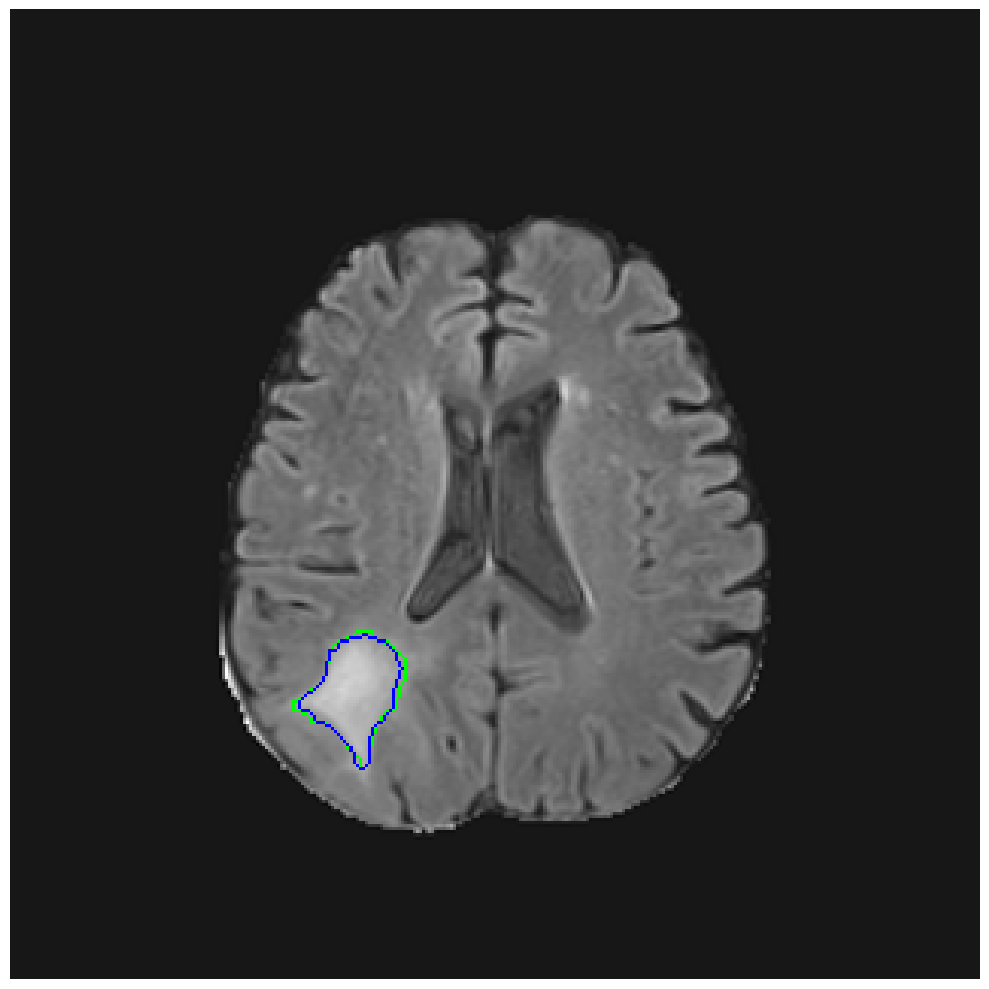

In [7]:
import torch

original_output = None


def hook_fn(module, input, output):
    global  original_output,original_input
    original_input = input
    original_output = output
    return output_o_1480.unsqueeze(0).unsqueeze(0)

hook_handle = model.conv1.register_forward_hook(hook_fn)


# def hook_fn(module, input, output, n_bits):
#     global original_output
#     original_output = output.clone().detach() 

#     tensor_min, tensor_max = output.min(), output.max()
#     normalized_tensor = (output - tensor_min) / (tensor_max - tensor_min)
#     scaled_tensor = normalized_tensor * (2**n_bits - 1)
#     quantized_tensor = torch.round(scaled_tensor).int()  # 转为整数
#     tmp = quantized_tensor.float() / (2**n_bits - 1) * (tensor_max - tensor_min) + tensor_min
#     return tmp

num_correct = 0
num_pixels = 0
dice_score = 0
per_image_dice_scores = []
model.eval()

# hook_handle = model.conv1.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, 4))

with torch.no_grad(): 
    for batch_idx, (x, y) in enumerate(test_loader):
        if batch_idx == closest_diff_indices[0]:
            x = x.to(DEVICE)
            y = y.to(DEVICE).unsqueeze(1)
            
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

            batch_size = x.size(0)
            result_image_std = draw_mask_contours_on_grayscale(x.cpu().numpy().squeeze(), y.cpu().numpy().squeeze(), color=(0, 255, 0), thickness=1) 
            result_image_std = draw_mask_contours_on_grayscale(result_image_std, preds.cpu().numpy().squeeze(), color=(255, 0, 0), thickness=1) 
            for i in range(batch_size):
                pred_single = preds[i]
                y_single = y[i]
                dice_single = (2 * (pred_single * y_single).sum()) / ((pred_single + y_single).sum() + 1e-8)
                per_image_dice_scores.append(dice_single.item())

hook_handle.remove()

Pixel_Accuracy = num_correct / num_pixels
Dice_Coefficient = dice_score / len(closest_diff_indices)

# 输出第一层卷积的计算结果
# print("First layer convolution output :", original_input)
print("First layer convolution output :", original_output)

# 返回 Pixel Accuracy 和 Dice Coefficient
print("Pixel Accuracy:", Pixel_Accuracy)
print("Dice Coefficient:", Dice_Coefficient)

print("Dice Coefficient:", per_image_dice_scores)

plt.figure(figsize=(10, 10)) 
    
# 显示带轮廓的图像 
plt.imshow(cv2.cvtColor(result_image_std, cv2.COLOR_BGR2RGB))  # OpenCV的BGR格式转换为RGB 
# plt.title("Grayscale with Mask Contours") 
plt.axis("off") 

# 显示图像 
plt.tight_layout() 
plt.savefig("image_1480_optical_quant.png", dpi=1024, bbox_inches='tight', pad_inches=0)
plt.show()

d:\anaconda3\envs\pytorch_gpu_base\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.22). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Loaded metrics from file:
Epoch History: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120]
Train Loss History: [0.37038404382104, 0.0718333214774904, 0.0294967267590646, 0.0204625701650249, 0.0175457376120171, 0.0160176922224831, 0.0147342310664547, 0.0138527281980509, 0.0134562240133734, 0.0124401681751326, 0.0125391171248381, 0.0113834874183022, 0.0109252291982965, 0.0108360767350036, 0.0102283475195889, 0.0100382600818656, 0.009624231807521, 0.009941616952185, 0.0090278947451041, 0.0090118785324704, 0.0088494826025899, 0.0086137649173346, 0.0083761

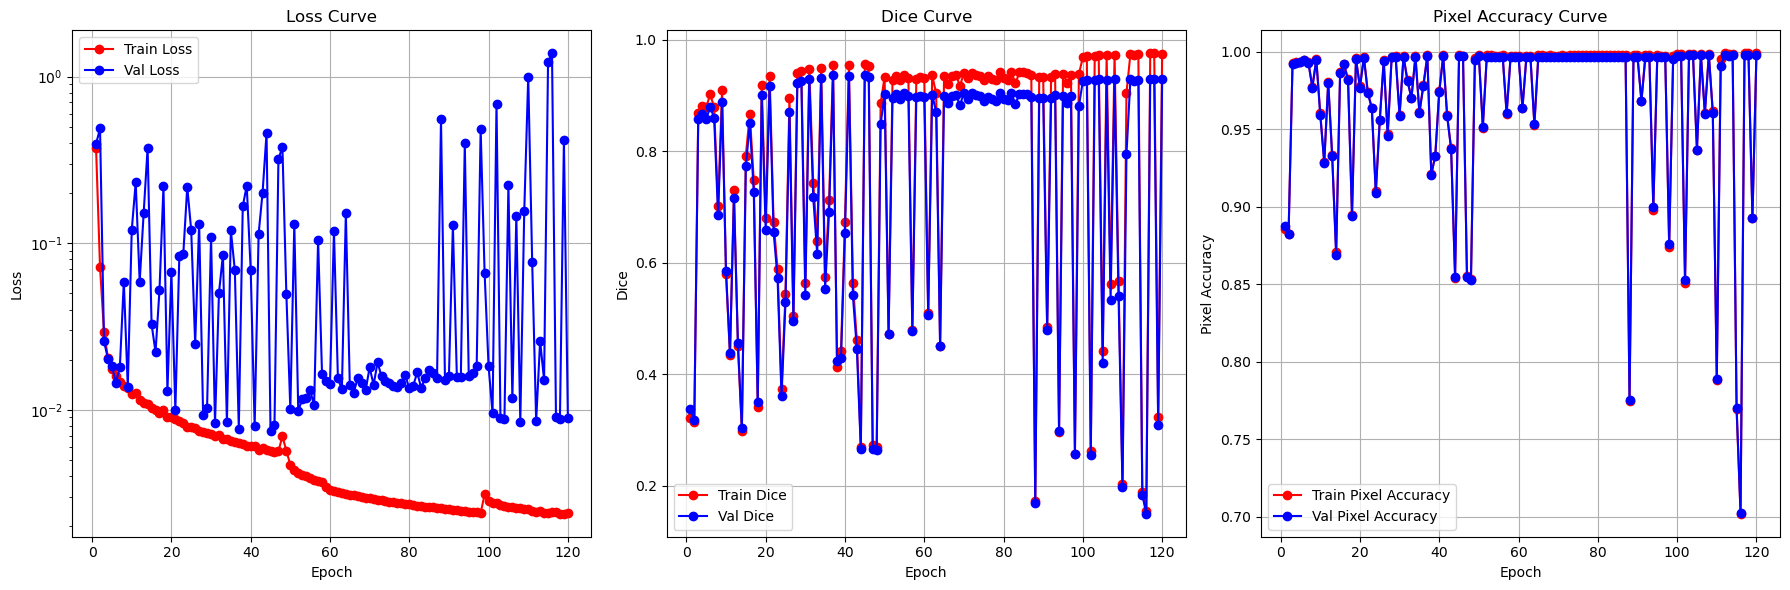

In [8]:
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from train import (
    METRICS_FILE,
    load_metrics_from_file,
)

if __name__ == "__main__":
    (
        epoch_history,
        train_loss_history,
        val_loss_history,
        train_dice_history,
        val_dice_history,
        train_pc_history,
        val_pc_history,
    ) = load_metrics_from_file()

    print("Loaded metrics from file:")
    print(f"Epoch History: {epoch_history}")
    print(f"Train Loss History: {train_loss_history}")
    print(f"Validation Loss History: {val_loss_history}")
    print(f"Train Dice History: {train_dice_history}")
    print(f"Validation Dice History: {val_dice_history}")
    print(f"Train Pixel Accuracy History: {train_pc_history}")
    print(f"Validation Pixel Accuracy History: {val_pc_history}")

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns
    
    axs[0].plot(epoch_history, train_loss_history, "r-o", label="Train Loss")
    axs[0].plot(epoch_history, val_loss_history, "b-o", label="Val Loss")
    axs[0].set_title("Loss Curve")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)
    axs[0].set_yscale("log")

    axs[1].plot(epoch_history, train_dice_history, "r-o", label="Train Dice")
    axs[1].plot(epoch_history, val_dice_history, "b-o", label="Val Dice")
    axs[1].set_title("Dice Curve")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Dice")
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(epoch_history, train_pc_history, "r-o", label="Train Pixel Accuracy")
    axs[2].plot(epoch_history, val_pc_history, "b-o", label="Val Pixel Accuracy")
    axs[2].set_title("Pixel Accuracy Curve")
    axs[2].set_xlabel("Epoch")
    axs[2].set_ylabel("Pixel Accuracy")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()
